# Load in model

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification


# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Sparse AE's

In [2]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

# Load training data

In [3]:
# max_seq_length=80 # max length of per data point
# from datasets import load_dataset
# # dataset_name = "NeelNanda/pile-10k"
# dataset_name = "stas/openwebtext-10k"
# dataset = load_dataset(dataset_name, split="train").map(
#     lambda x: tokenizer(x['text']),
#     batched=True
# ).filter(
#     lambda x: len(x['input_ids']) > max_seq_length
# ).map(
#     lambda x: {'input_ids': x['input_ids'][:max_seq_length]}
# )

In [4]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
cfg = dotdict()

cfg.dataset_name="stas/openwebtext-10k"
cfg.max_length = 256
cfg.model_batch_size = 4
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")
num_features, d_model = autoencoder.encoder.shape

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11226112


## Model Definitions

In [5]:
from torch.optim import Adam
from torch import nn
class sparse_two_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x
    
class mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

    
class sparse_nonlinear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class linear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        return x

class linear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return x


In [ ]:

initialize_weights = False
num_features, d_model = autoencoder.encoder.shape
two_nonlinear_weights = []
mlp_weights = []
nonlinear_weights = []
linear_weights = []
mlp_weights_no_bias = []
nonlinear_weights_no_bias = []
linear_weights_no_bias = []

two_nonlinear_optimizers = []
mlp_optimizers = []
nonlinear_optimizers = []
linear_optimizers = []
mlp_optimizers_no_bias = []
nonlinear_optimizers_no_bias = []
linear_optimizers_no_bias = []
for auto_ind in range(len(autoencoders)//2):
    two_nonlinear_weights.append(sparse_two_nonlinear(num_features))
    two_nonlinear_weights[-1].to(device)
    two_nonlinear_optimizers.append(Adam(two_nonlinear_weights[-1].parameters(), lr=1e-3))

    mlp_weights.append(mlp(num_features))
    mlp_weights[-1].to(device)
    mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

    mlp_weights_no_bias.append(mlp_no_bias(num_features))
    mlp_weights_no_bias[-1].to(device)
    mlp_optimizers_no_bias.append(Adam(mlp_weights_no_bias[-1].parameters(), lr=1e-3))

    nonlinear_weights.append(sparse_nonlinear(num_features))
    nonlinear_weights[-1].to(device)
    nonlinear_optimizers.append(Adam(nonlinear_weights[-1].parameters(), lr=1e-3))

    nonlinear_weights_no_bias.append(sparse_nonlinear_no_bias(num_features))
    nonlinear_weights_no_bias[-1].to(device)
    nonlinear_optimizers_no_bias.append(Adam(nonlinear_weights_no_bias[-1].parameters(), lr=1e-3))

    linear_weights.append(linear(num_features))
    linear_weights[-1].to(device)
    linear_optimizers.append(Adam(linear_weights[-1].parameters(), lr=1e-3))

    linear_weights_no_bias.append(linear_no_bias(num_features))
    linear_weights_no_bias[-1].to(device)
    linear_optimizers_no_bias.append(Adam(linear_weights_no_bias[-1].parameters(), lr=1e-3))

    if(initialize_weights):
        # Multiply the decoder weights by mlp weights & second autoencoder's encoder weights
        decoder = autoencoders[auto_ind].encoder
        mlp_enc = model.gpt_neox.layers[auto_ind+1].mlp.dense_h_to_4h.weight.detach().T
        mlp_dec = model.gpt_neox.layers[auto_ind+1].mlp.dense_4h_to_h.weight.detach().T
        encoder = autoencoders[auto_ind+1].encoder.T
        initial_weights = decoder @ mlp_enc @ mlp_dec @ encoder
        nonlinear_weights[-1].linear.weight.data = initial_weights
        linear_weights[-1].linear.weight.data = initial_weights

## Find Dead Features in Output layers

In [6]:
from baukit import TraceDict

total_batches = 100
feature_activations = torch.zeros((len(autoencoders)//2, num_features))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
    
        for cache_name_ind in range(len(cache_names) // 2):
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            output_activations = ret[output_cache_name].output
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            feature_activations[cache_name_ind] += output_internal_activations.sum(dim=0).cpu()
        if i > total_batches:
            break
    alive_features_ind = (feature_activations != 0)
    alive_features_ind = alive_features_ind

  1%|          | 101/10963 [00:03<06:35, 27.46it/s]


## Train the model

In [68]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    l1_alpha = 1e-3
    batch_size = 32
    losses = [[] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            x_hat = sparse_weights[cache_name_ind](input_internal_activations)

            # loss = mse(x_hat, output_internal_activations)
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
            indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
            loss = mse(indexed_x_hat, indexed_output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())

            if i % 100 == 0:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
            
        if i > 300:
            # Stop training after 1000 batches
            break
    return losses
two_nonlinear_losses = train_sparse_model(model, dataset, device, two_nonlinear_weights, autoencoders, cache_names, two_nonlinear_optimizers)
mlp_losses = train_sparse_model(model, dataset, device, mlp_weights, autoencoders, cache_names, mlp_optimizers)

nonlinear_losses = train_sparse_model(model, dataset, device, nonlinear_weights, autoencoders, cache_names, nonlinear_optimizers)
linear_losses = train_sparse_model(model, dataset, device, linear_weights, autoencoders, cache_names, linear_optimizers)

mlp_losses_no_bias = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)
nonlinear_losses_no_bias = train_sparse_model(model, dataset, device, nonlinear_weights_no_bias, autoencoders, cache_names, nonlinear_optimizers_no_bias)
linear_losses_no_bias = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias)


  0%|          | 1/10963 [00:00<30:26,  6.00it/s]

Layers: 0 | MSE Loss: 0.002709051361307502 | L1 Loss: 33.1937255859375
Layers: 1 | MSE Loss: 0.006415734998881817 | L1 Loss: 40.044944763183594
Layers: 2 | MSE Loss: 0.007123843766748905 | L1 Loss: 38.38678741455078
Layers: 3 | MSE Loss: 0.011819090694189072 | L1 Loss: 36.529266357421875
Layers: 4 | MSE Loss: 0.13606832921504974 | L1 Loss: 46.254234313964844


  1%|          | 101/10963 [00:16<29:18,  6.18it/s]

Layers: 0 | MSE Loss: 0.0025959566701203585 | L1 Loss: 34.75420379638672
Layers: 1 | MSE Loss: 0.007729507051408291 | L1 Loss: 42.7813720703125
Layers: 2 | MSE Loss: 0.007919395342469215 | L1 Loss: 41.360755920410156
Layers: 3 | MSE Loss: 0.013601090759038925 | L1 Loss: 38.513214111328125
Layers: 4 | MSE Loss: 0.0809486135840416 | L1 Loss: 47.254310607910156


  2%|▏         | 201/10963 [00:32<29:16,  6.13it/s]

Layers: 0 | MSE Loss: 0.002455382840707898 | L1 Loss: 36.24231719970703
Layers: 1 | MSE Loss: 0.005372575018554926 | L1 Loss: 45.19855880737305
Layers: 2 | MSE Loss: 0.006856810301542282 | L1 Loss: 44.20817565917969
Layers: 3 | MSE Loss: 0.010839097201824188 | L1 Loss: 40.4603271484375
Layers: 4 | MSE Loss: 0.08639892190694809 | L1 Loss: 48.648345947265625


  3%|▎         | 301/10963 [00:48<29:34,  6.01it/s]

Layers: 0 | MSE Loss: 0.0026961525436490774 | L1 Loss: 37.53596115112305
Layers: 1 | MSE Loss: 0.0069549852050840855 | L1 Loss: 47.2735710144043
Layers: 2 | MSE Loss: 0.007188647985458374 | L1 Loss: 46.898712158203125
Layers: 3 | MSE Loss: 0.010922875255346298 | L1 Loss: 42.3124885559082
Layers: 4 | MSE Loss: 0.06456266343593597 | L1 Loss: 49.811885833740234


  0%|          | 1/10963 [00:00<30:23,  6.01it/s]

Layers: 0 | MSE Loss: 0.005025099031627178 | L1 Loss: 27.7119140625
Layers: 1 | MSE Loss: 0.06453674286603928 | L1 Loss: 27.710922241210938
Layers: 2 | MSE Loss: 0.025250323116779327 | L1 Loss: 27.70709800720215
Layers: 3 | MSE Loss: 0.05216137319803238 | L1 Loss: 27.71053123474121
Layers: 4 | MSE Loss: 4.229884624481201 | L1 Loss: 27.716108322143555


  1%|          | 101/10963 [00:16<30:09,  6.00it/s]

Layers: 0 | MSE Loss: 0.0015538648003712296 | L1 Loss: 30.15362548828125
Layers: 1 | MSE Loss: 0.004450476262718439 | L1 Loss: 35.71733856201172
Layers: 2 | MSE Loss: 0.004284085240215063 | L1 Loss: 33.81321334838867
Layers: 3 | MSE Loss: 0.005677566397935152 | L1 Loss: 34.236141204833984
Layers: 4 | MSE Loss: 0.1502651423215866 | L1 Loss: 45.50469970703125


  2%|▏         | 201/10963 [00:33<29:55,  5.99it/s]

Layers: 0 | MSE Loss: 0.0012070517987012863 | L1 Loss: 32.813262939453125
Layers: 1 | MSE Loss: 0.004639974795281887 | L1 Loss: 38.999446868896484
Layers: 2 | MSE Loss: 0.0036032332573086023 | L1 Loss: 37.45502471923828
Layers: 3 | MSE Loss: 0.004333812743425369 | L1 Loss: 38.73706817626953
Layers: 4 | MSE Loss: 0.07441774010658264 | L1 Loss: 46.57115936279297


  3%|▎         | 301/10963 [00:50<29:37,  6.00it/s]

Layers: 0 | MSE Loss: 0.0010626455768942833 | L1 Loss: 34.69009780883789
Layers: 1 | MSE Loss: 0.0031765783205628395 | L1 Loss: 41.56261444091797
Layers: 2 | MSE Loss: 0.0033932204823940992 | L1 Loss: 40.02840805053711
Layers: 3 | MSE Loss: 0.0037410990335047245 | L1 Loss: 41.87997055053711
Layers: 4 | MSE Loss: 0.04685224965214729 | L1 Loss: 48.083221435546875


  0%|          | 2/10963 [00:00<16:57, 10.78it/s]

Layers: 0 | MSE Loss: 0.004534679930657148 | L1 Loss: 27.713333129882812
Layers: 1 | MSE Loss: 0.05962499603629112 | L1 Loss: 27.719833374023438
Layers: 2 | MSE Loss: 0.022990413010120392 | L1 Loss: 27.708694458007812
Layers: 3 | MSE Loss: 0.0529414564371109 | L1 Loss: 27.71822166442871
Layers: 4 | MSE Loss: 4.126617908477783 | L1 Loss: 27.706785202026367


  1%|          | 102/10963 [00:09<16:51, 10.74it/s]

Layers: 0 | MSE Loss: 0.0036679452750831842 | L1 Loss: 26.95979881286621
Layers: 1 | MSE Loss: 0.053494714200496674 | L1 Loss: 28.246564865112305
Layers: 2 | MSE Loss: 0.011679899878799915 | L1 Loss: 29.577787399291992
Layers: 3 | MSE Loss: 0.02149686962366104 | L1 Loss: 29.497983932495117
Layers: 4 | MSE Loss: 3.449294090270996 | L1 Loss: 30.160812377929688


  2%|▏         | 202/10963 [00:18<16:32, 10.84it/s]

Layers: 0 | MSE Loss: 0.002754510147497058 | L1 Loss: 27.5905818939209
Layers: 1 | MSE Loss: 0.04195837303996086 | L1 Loss: 29.899572372436523
Layers: 2 | MSE Loss: 0.008827945217490196 | L1 Loss: 32.831214904785156
Layers: 3 | MSE Loss: 0.017127707600593567 | L1 Loss: 31.659374237060547
Layers: 4 | MSE Loss: 3.520958423614502 | L1 Loss: 32.66560363769531


  3%|▎         | 301/10963 [00:28<16:31, 10.75it/s]


Layers: 0 | MSE Loss: 0.003111104713752866 | L1 Loss: 28.47802734375
Layers: 1 | MSE Loss: 0.042431678622961044 | L1 Loss: 31.49228286743164
Layers: 2 | MSE Loss: 0.00683586485683918 | L1 Loss: 35.95781707763672
Layers: 3 | MSE Loss: 0.01042618602514267 | L1 Loss: 33.75437927246094
Layers: 4 | MSE Loss: 3.2045326232910156 | L1 Loss: 34.80744934082031


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.006891225464642048 | L1 Loss: 27.716751098632812


  0%|          | 2/10963 [00:00<17:01, 10.73it/s]

Layers: 1 | MSE Loss: 0.06769532710313797 | L1 Loss: 27.72212791442871
Layers: 2 | MSE Loss: 0.035101182758808136 | L1 Loss: 27.719085693359375
Layers: 3 | MSE Loss: 0.06578302383422852 | L1 Loss: 27.71672821044922
Layers: 4 | MSE Loss: 3.832160711288452 | L1 Loss: 27.71137237548828


  1%|          | 102/10963 [00:09<16:32, 10.94it/s]

Layers: 0 | MSE Loss: 0.003572833025828004 | L1 Loss: 21.34664535522461
Layers: 1 | MSE Loss: 0.05850654095411301 | L1 Loss: 23.646892547607422
Layers: 2 | MSE Loss: 0.011093825101852417 | L1 Loss: 21.978557586669922
Layers: 3 | MSE Loss: 0.022732596844434738 | L1 Loss: 22.41079330444336
Layers: 4 | MSE Loss: 3.626394748687744 | L1 Loss: 25.06655502319336


  2%|▏         | 202/10963 [00:18<16:29, 10.87it/s]

Layers: 0 | MSE Loss: 0.0028638013172894716 | L1 Loss: 21.570669174194336
Layers: 1 | MSE Loss: 0.04001371189951897 | L1 Loss: 24.05171775817871
Layers: 2 | MSE Loss: 0.008201072923839092 | L1 Loss: 22.305965423583984
Layers: 3 | MSE Loss: 0.012674156576395035 | L1 Loss: 22.426502227783203
Layers: 4 | MSE Loss: 3.1911420822143555 | L1 Loss: 25.217824935913086


  3%|▎         | 301/10963 [00:27<16:22, 10.85it/s]


Layers: 0 | MSE Loss: 0.003007551422342658 | L1 Loss: 21.71480369567871
Layers: 1 | MSE Loss: 0.03938260301947594 | L1 Loss: 24.20284080505371
Layers: 2 | MSE Loss: 0.006919376086443663 | L1 Loss: 22.29537010192871
Layers: 3 | MSE Loss: 0.010357106104493141 | L1 Loss: 22.477384567260742
Layers: 4 | MSE Loss: 3.484081268310547 | L1 Loss: 25.360145568847656


  0%|          | 1/10963 [00:00<33:00,  5.54it/s]

Layers: 0 | MSE Loss: 0.004240714944899082 | L1 Loss: 27.711254119873047
Layers: 1 | MSE Loss: 0.05875673145055771 | L1 Loss: 27.70465087890625
Layers: 2 | MSE Loss: 0.023982767015695572 | L1 Loss: 27.711761474609375
Layers: 3 | MSE Loss: 0.05168703570961952 | L1 Loss: 27.710065841674805
Layers: 4 | MSE Loss: 4.153321743011475 | L1 Loss: 27.716123580932617


  1%|          | 101/10963 [00:17<30:27,  5.94it/s]

Layers: 0 | MSE Loss: 0.001523811835795641 | L1 Loss: 30.205650329589844
Layers: 1 | MSE Loss: 0.007355864159762859 | L1 Loss: 35.95829391479492
Layers: 2 | MSE Loss: 0.0042594498954713345 | L1 Loss: 33.910621643066406
Layers: 3 | MSE Loss: 0.005368053913116455 | L1 Loss: 34.17935562133789
Layers: 4 | MSE Loss: 0.11323649436235428 | L1 Loss: 46.19349670410156


  2%|▏         | 201/10963 [00:34<30:28,  5.89it/s]

Layers: 0 | MSE Loss: 0.0011674172710627317 | L1 Loss: 32.86808776855469
Layers: 1 | MSE Loss: 0.0036502087023109198 | L1 Loss: 38.91054916381836
Layers: 2 | MSE Loss: 0.0034480798058211803 | L1 Loss: 37.544986724853516
Layers: 3 | MSE Loss: 0.004573638550937176 | L1 Loss: 38.59242248535156
Layers: 4 | MSE Loss: 0.08172038197517395 | L1 Loss: 47.428855895996094


  3%|▎         | 301/10963 [00:51<30:30,  5.82it/s]

Layers: 0 | MSE Loss: 0.0010105047840625048 | L1 Loss: 34.826202392578125
Layers: 1 | MSE Loss: 0.004550555255264044 | L1 Loss: 41.07575607299805
Layers: 2 | MSE Loss: 0.00342276762239635 | L1 Loss: 39.96735763549805
Layers: 3 | MSE Loss: 0.004236152861267328 | L1 Loss: 41.63082504272461
Layers: 4 | MSE Loss: 0.07091832160949707 | L1 Loss: 48.89036178588867


  0%|          | 2/10963 [00:00<17:21, 10.53it/s]

Layers: 0 | MSE Loss: 0.005351641681045294 | L1 Loss: 27.716102600097656
Layers: 1 | MSE Loss: 0.06868107616901398 | L1 Loss: 27.72601890563965
Layers: 2 | MSE Loss: 0.027781372889876366 | L1 Loss: 27.70662498474121
Layers: 3 | MSE Loss: 0.06100301072001457 | L1 Loss: 27.707870483398438
Layers: 4 | MSE Loss: 4.163174152374268 | L1 Loss: 27.719457626342773


  1%|          | 102/10963 [00:09<17:09, 10.55it/s]

Layers: 0 | MSE Loss: 0.0036196515429764986 | L1 Loss: 26.85170555114746
Layers: 1 | MSE Loss: 0.05422477424144745 | L1 Loss: 28.169591903686523
Layers: 2 | MSE Loss: 0.01017084438353777 | L1 Loss: 29.57203483581543
Layers: 3 | MSE Loss: 0.023420045152306557 | L1 Loss: 29.39895248413086
Layers: 4 | MSE Loss: 3.559314250946045 | L1 Loss: 29.973365783691406


  2%|▏         | 202/10963 [00:19<16:53, 10.62it/s]

Layers: 0 | MSE Loss: 0.0027219767216593027 | L1 Loss: 27.303396224975586
Layers: 1 | MSE Loss: 0.04715669900178909 | L1 Loss: 29.51919937133789
Layers: 2 | MSE Loss: 0.008107679896056652 | L1 Loss: 32.73406982421875
Layers: 3 | MSE Loss: 0.01710367016494274 | L1 Loss: 31.57220458984375
Layers: 4 | MSE Loss: 3.531963586807251 | L1 Loss: 32.365257263183594


  3%|▎         | 301/10963 [00:28<16:53, 10.52it/s]


Layers: 0 | MSE Loss: 0.003088452620431781 | L1 Loss: 27.961423873901367
Layers: 1 | MSE Loss: 0.03864886611700058 | L1 Loss: 30.902557373046875
Layers: 2 | MSE Loss: 0.007399913854897022 | L1 Loss: 35.698699951171875
Layers: 3 | MSE Loss: 0.014638030901551247 | L1 Loss: 33.69678497314453
Layers: 4 | MSE Loss: 3.3558852672576904 | L1 Loss: 34.312530517578125


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.006188115105032921 | L1 Loss: 27.715938568115234


  0%|          | 1/10963 [00:00<19:58,  9.14it/s]

Layers: 1 | MSE Loss: 0.057518549263477325 | L1 Loss: 27.71747589111328
Layers: 2 | MSE Loss: 0.030299214646220207 | L1 Loss: 27.719741821289062
Layers: 3 | MSE Loss: 0.05934148281812668 | L1 Loss: 27.713682174682617
Layers: 4 | MSE Loss: 3.7120611667633057 | L1 Loss: 27.71194839477539


  1%|          | 101/10963 [00:09<16:55, 10.70it/s]

Layers: 0 | MSE Loss: 0.0035619938280433416 | L1 Loss: 20.96864891052246
Layers: 1 | MSE Loss: 0.056925319135189056 | L1 Loss: 23.44717025756836
Layers: 2 | MSE Loss: 0.011126273311674595 | L1 Loss: 21.9727840423584
Layers: 3 | MSE Loss: 0.02293139509856701 | L1 Loss: 22.44025230407715
Layers: 4 | MSE Loss: 3.9015986919403076 | L1 Loss: 24.9989070892334


  2%|▏         | 201/10963 [00:18<16:45, 10.70it/s]

Layers: 0 | MSE Loss: 0.0030521133448928595 | L1 Loss: 20.70962142944336
Layers: 1 | MSE Loss: 0.045904844999313354 | L1 Loss: 23.72765350341797
Layers: 2 | MSE Loss: 0.008170104585587978 | L1 Loss: 22.17218589782715
Layers: 3 | MSE Loss: 0.013811702840030193 | L1 Loss: 22.399877548217773
Layers: 4 | MSE Loss: 3.067172050476074 | L1 Loss: 25.185155868530273


  3%|▎         | 301/10963 [00:28<16:49, 10.56it/s]

Layers: 0 | MSE Loss: 0.0025788983330130577 | L1 Loss: 20.71686553955078
Layers: 1 | MSE Loss: 0.046794261783361435 | L1 Loss: 23.896709442138672
Layers: 2 | MSE Loss: 0.006782630458474159 | L1 Loss: 22.258968353271484
Layers: 3 | MSE Loss: 0.010508264414966106 | L1 Loss: 22.444225311279297
Layers: 4 | MSE Loss: 3.2288239002227783 | L1 Loss: 25.345050811767578


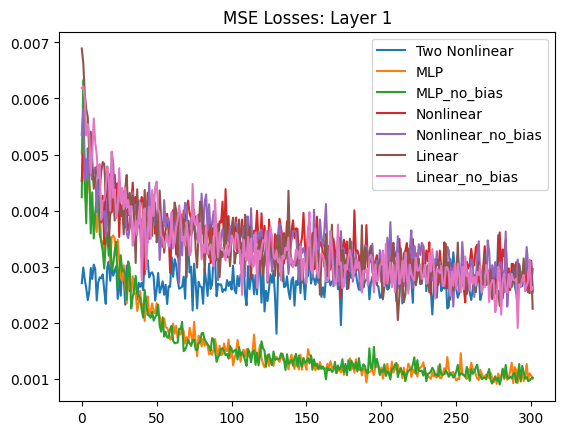

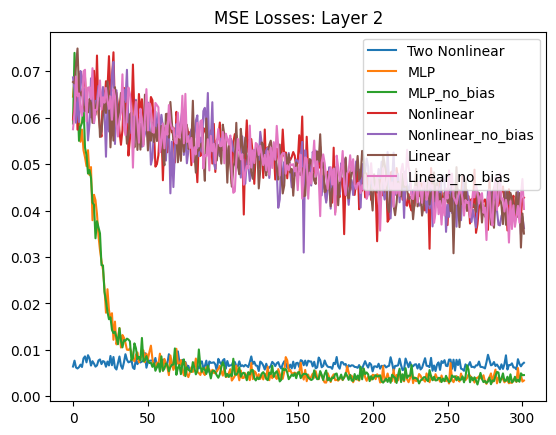

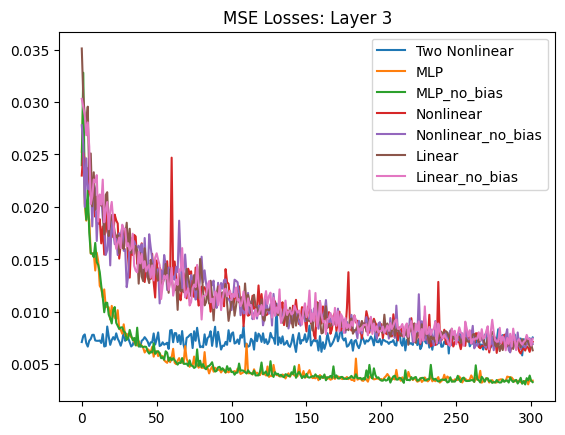

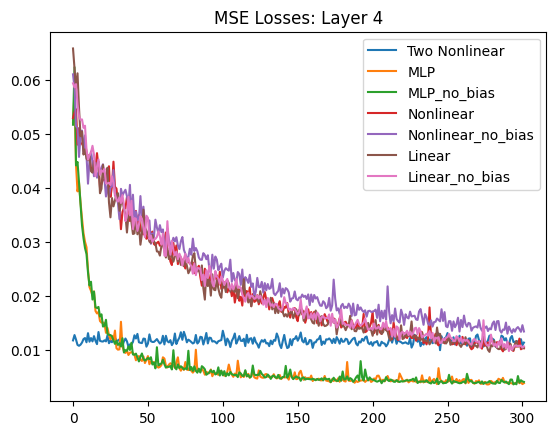

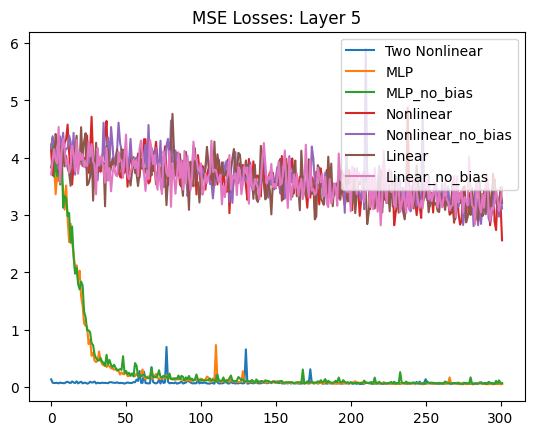

In [69]:
# Plot both losses
import matplotlib.pyplot as plt
for layer in range(len(two_nonlinear_losses)):
    # make a new plot
    plt.figure()
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer])
    plt.plot(mlp_losses[layer])
    plt.plot(mlp_losses_no_bias[layer])
    plt.plot(nonlinear_losses[layer])
    plt.plot(nonlinear_losses_no_bias[layer])
    plt.plot(linear_losses[layer])
    plt.plot(linear_losses_no_bias[layer])
    plt.legend(["Two Nonlinear", "MLP", "MLP_no_bias", "Nonlinear", "Nonlinear_no_bias", "Linear", "Linear_no_bias"])
plt.show()

## Pareto frontier of l1 alpha for linear layer (no bias), then MLP (no bias)

In [7]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 10
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features))
        # mlp_weights_no_bias[-1][-1].to(device)
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))

        linear_weights_no_bias[-1].append(linear_no_bias(num_features))
        # linear_weights_no_bias[-1][-1].to(device)
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [8]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, l1_alphas):
    mse = nn.MSELoss()
    batch_size = 32
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
                sparse_weight = sparse_weights[cache_name_ind][l1_alpha_ind].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                unweighted_loss = mse_loss + l1_loss
                loss = mse_loss + l1_alpha * l1_loss

                loss.backward()
                optimizers[cache_name_ind][l1_alpha_ind].step()
                optimizers[cache_name_ind][l1_alpha_ind].zero_grad()
                losses[cache_name_ind][l1_alpha_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][l1_alpha_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][l1_alpha_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, current_alive_features_ind, mse_loss, unweighted_loss
                torch.cuda.empty_cache()

            
        if i > 300:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1
# l1_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 100]
l1_alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, .1, 1]

mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004733354784548283 | L1 Loss: 27.71285057067871
Layers: 0 | l1 alpha MSE Loss: 0.004719187039881945 | L1 Loss: 27.709638595581055
Layers: 0 | l1 alpha MSE Loss: 0.004732029512524605 | L1 Loss: 27.707304000854492
Layers: 0 | l1 alpha MSE Loss: 0.004733816254884005 | L1 Loss: 27.71148681640625
Layers: 0 | l1 alpha MSE Loss: 0.004734257236123085 | L1 Loss: 27.708663940429688
Layers: 0 | l1 alpha MSE Loss: 0.0047302283346652985 | L1 Loss: 27.70979118347168
Layers: 0 | l1 alpha MSE Loss: 0.004723918624222279 | L1 Loss: 27.72267723083496
Layers: 0 | l1 alpha MSE Loss: 0.004736197181046009 | L1 Loss: 27.71916961669922
Layers: 1 | l1 alpha MSE Loss: 0.06439153850078583 | L1 Loss: 27.713092803955078
Layers: 1 | l1 alpha MSE Loss: 0.06442505121231079 | L1 Loss: 27.714508056640625
Layers: 1 | l1 alpha MSE Loss: 0.06451000273227692 | L1 Loss: 27.712875366210938
Layers: 1 | l1 alpha MSE Loss: 0.06446237117052078 | L1 Loss: 27.711326599121094
Layers: 1 | l1 alpha MSE

  0%|          | 1/10963 [00:04<12:53:12,  4.23s/it]

Layers: 4 | l1 alpha MSE Loss: 4.045109272003174 | L1 Loss: 27.718862533569336
Layers: 4 | l1 alpha MSE Loss: 4.037631511688232 | L1 Loss: 27.712093353271484


  1%|          | 100/10963 [07:06<13:34:31,  4.50s/it]

Layers: 0 | l1 alpha MSE Loss: 0.0014814231544733047 | L1 Loss: 29.73201560974121
Layers: 0 | l1 alpha MSE Loss: 0.0014711512485519052 | L1 Loss: 25.611129760742188
Layers: 0 | l1 alpha MSE Loss: 0.0014765466330572963 | L1 Loss: 11.847331047058105
Layers: 0 | l1 alpha MSE Loss: 0.0016996891936287284 | L1 Loss: 4.244791030883789
Layers: 0 | l1 alpha MSE Loss: 0.002673329319804907 | L1 Loss: 0.7933425903320312
Layers: 0 | l1 alpha MSE Loss: 0.003817987395450473 | L1 Loss: 0.4023781716823578
Layers: 0 | l1 alpha MSE Loss: 0.00455043138936162 | L1 Loss: 0.37991756200790405
Layers: 0 | l1 alpha MSE Loss: 0.004600435495376587 | L1 Loss: 0.38169464468955994
Layers: 1 | l1 alpha MSE Loss: 0.004626172129064798 | L1 Loss: 35.83137130737305
Layers: 1 | l1 alpha MSE Loss: 0.004596203565597534 | L1 Loss: 34.049835205078125
Layers: 1 | l1 alpha MSE Loss: 0.00459839403629303 | L1 Loss: 25.794445037841797
Layers: 1 | l1 alpha MSE Loss: 0.0047584595158696175 | L1 Loss: 12.654579162597656
Layers: 1 | l1

  1%|          | 101/10963 [07:11<13:27:49,  4.46s/it]

Layers: 4 | l1 alpha MSE Loss: 0.3288430869579315 | L1 Loss: 0.5468597412109375


  2%|▏         | 200/10963 [14:13<13:07:03,  4.39s/it]

Layers: 0 | l1 alpha MSE Loss: 0.0013017490273341537 | L1 Loss: 31.975872039794922
Layers: 0 | l1 alpha MSE Loss: 0.0012933457037433982 | L1 Loss: 25.4152889251709
Layers: 0 | l1 alpha MSE Loss: 0.0013097759801894426 | L1 Loss: 13.09552001953125
Layers: 0 | l1 alpha MSE Loss: 0.0014795787865296006 | L1 Loss: 4.349245548248291
Layers: 0 | l1 alpha MSE Loss: 0.0023107200395315886 | L1 Loss: 0.7862086296081543
Layers: 0 | l1 alpha MSE Loss: 0.0034448415972292423 | L1 Loss: 0.37855514883995056
Layers: 0 | l1 alpha MSE Loss: 0.003942614886909723 | L1 Loss: 0.35948845744132996
Layers: 0 | l1 alpha MSE Loss: 0.004059121944010258 | L1 Loss: 0.36912256479263306
Layers: 1 | l1 alpha MSE Loss: 0.005467777140438557 | L1 Loss: 38.870269775390625
Layers: 1 | l1 alpha MSE Loss: 0.005442210007458925 | L1 Loss: 36.214237213134766
Layers: 1 | l1 alpha MSE Loss: 0.005321325734257698 | L1 Loss: 26.90798568725586
Layers: 1 | l1 alpha MSE Loss: 0.005044763907790184 | L1 Loss: 11.90423583984375
Layers: 1 | l

  2%|▏         | 201/10963 [14:17<13:04:32,  4.37s/it]

Layers: 4 | l1 alpha MSE Loss: 0.1359824240207672 | L1 Loss: 1.289018154144287
Layers: 4 | l1 alpha MSE Loss: 0.2363884001970291 | L1 Loss: 0.5111936330795288


  3%|▎         | 300/10963 [21:09<12:14:00,  4.13s/it]

Layers: 0 | l1 alpha MSE Loss: 0.001033222652040422 | L1 Loss: 33.62773132324219
Layers: 0 | l1 alpha MSE Loss: 0.0010361666791141033 | L1 Loss: 25.35782241821289
Layers: 0 | l1 alpha MSE Loss: 0.0010477106552571058 | L1 Loss: 13.720748901367188
Layers: 0 | l1 alpha MSE Loss: 0.001224427716806531 | L1 Loss: 4.327743053436279
Layers: 0 | l1 alpha MSE Loss: 0.0020748667884618044 | L1 Loss: 0.8005441427230835
Layers: 0 | l1 alpha MSE Loss: 0.0035618157126009464 | L1 Loss: 0.3750793933868408
Layers: 0 | l1 alpha MSE Loss: 0.004268457647413015 | L1 Loss: 0.3577389717102051
Layers: 0 | l1 alpha MSE Loss: 0.004517522640526295 | L1 Loss: 0.3725905418395996
Layers: 1 | l1 alpha MSE Loss: 0.0034841448068618774 | L1 Loss: 41.082794189453125
Layers: 1 | l1 alpha MSE Loss: 0.003465541871264577 | L1 Loss: 37.71931838989258
Layers: 1 | l1 alpha MSE Loss: 0.00348118063993752 | L1 Loss: 27.383590698242188
Layers: 1 | l1 alpha MSE Loss: 0.0036988554056733847 | L1 Loss: 11.641538619995117
Layers: 1 | l1 

  3%|▎         | 301/10963 [21:13<12:10:42,  4.11s/it]

Layers: 4 | l1 alpha MSE Loss: 0.2344096153974533 | L1 Loss: 0.5003706216812134


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.006284926552325487 | L1 Loss: 27.715389251708984
Layers: 0 | l1 alpha MSE Loss: 0.006334547419101 | L1 Loss: 27.7131404876709
Layers: 0 | l1 alpha MSE Loss: 0.006310426630079746 | L1 Loss: 27.702985763549805
Layers: 0 | l1 alpha MSE Loss: 0.006304795388132334 | L1 Loss: 27.71136474609375
Layers: 0 | l1 alpha MSE Loss: 0.006299997679889202 | L1 Loss: 27.712661743164062
Layers: 0 | l1 alpha MSE Loss: 0.0063200583681464195 | L1 Loss: 27.721126556396484
Layers: 0 | l1 alpha MSE Loss: 0.006298281718045473 | L1 Loss: 27.704105377197266
Layers: 0 | l1 alpha MSE Loss: 0.0062978207133710384 | L1 Loss: 27.710485458374023
Layers: 1 | l1 alpha MSE Loss: 0.0707874670624733 | L1 Loss: 27.714643478393555
Layers: 1 | l1 alpha MSE Loss: 0.0703941211104393 | L1 Loss: 27.711645126342773
Layers: 1 | l1 alpha MSE Loss: 0.07028399407863617 | L1 Loss: 27.70416831970215
Layers: 1 | l1 alpha MSE Loss: 0.07052814215421677 | L1 Loss: 27.725418090820312
Layers: 1 | l1 alpha MSE Lo

  0%|          | 1/10963 [00:02<6:49:37,  2.24s/it]

Layers: 4 | l1 alpha MSE Loss: 4.031639099121094 | L1 Loss: 27.71376609802246
Layers: 4 | l1 alpha MSE Loss: 4.021484375 | L1 Loss: 27.703405380249023
Layers: 4 | l1 alpha MSE Loss: 4.042320728302002 | L1 Loss: 27.71856689453125


  1%|          | 100/10963 [03:58<7:17:22,  2.42s/it]

Layers: 0 | l1 alpha MSE Loss: 0.003575268667191267 | L1 Loss: 20.290424346923828
Layers: 0 | l1 alpha MSE Loss: 0.003570804139599204 | L1 Loss: 14.717814445495605
Layers: 0 | l1 alpha MSE Loss: 0.003570947330445051 | L1 Loss: 1.0467480421066284
Layers: 0 | l1 alpha MSE Loss: 0.0035575462970882654 | L1 Loss: 0.5577316284179688
Layers: 0 | l1 alpha MSE Loss: 0.0036255863960832357 | L1 Loss: 0.4325332045555115
Layers: 0 | l1 alpha MSE Loss: 0.0038142919074743986 | L1 Loss: 0.39253291487693787
Layers: 0 | l1 alpha MSE Loss: 0.004196557216346264 | L1 Loss: 0.38281816244125366
Layers: 0 | l1 alpha MSE Loss: 0.004456736147403717 | L1 Loss: 0.3817926347255707
Layers: 1 | l1 alpha MSE Loss: 0.05156732723116875 | L1 Loss: 22.741230010986328
Layers: 1 | l1 alpha MSE Loss: 0.051385700702667236 | L1 Loss: 16.59762191772461
Layers: 1 | l1 alpha MSE Loss: 0.05127725005149841 | L1 Loss: 1.754389762878418
Layers: 1 | l1 alpha MSE Loss: 0.05152493715286255 | L1 Loss: 1.061964988708496
Layers: 1 | l1 al

  1%|          | 101/10963 [04:00<7:23:57,  2.45s/it]

Layers: 4 | l1 alpha MSE Loss: 3.813183546066284 | L1 Loss: 1.275310754776001
Layers: 4 | l1 alpha MSE Loss: 3.8214871883392334 | L1 Loss: 0.6347795724868774
Layers: 4 | l1 alpha MSE Loss: 3.8203747272491455 | L1 Loss: 0.45045340061187744
Layers: 4 | l1 alpha MSE Loss: 3.873538017272949 | L1 Loss: 0.40668797492980957


  2%|▏         | 200/10963 [07:58<7:39:19,  2.56s/it]

Layers: 0 | l1 alpha MSE Loss: 0.003101669019088149 | L1 Loss: 19.34798812866211
Layers: 0 | l1 alpha MSE Loss: 0.0031006145291030407 | L1 Loss: 9.478221893310547
Layers: 0 | l1 alpha MSE Loss: 0.0031035118736326694 | L1 Loss: 0.959304690361023
Layers: 0 | l1 alpha MSE Loss: 0.0031058781314641237 | L1 Loss: 0.6336278915405273
Layers: 0 | l1 alpha MSE Loss: 0.003171845804899931 | L1 Loss: 0.44794008135795593
Layers: 0 | l1 alpha MSE Loss: 0.003489818423986435 | L1 Loss: 0.38707906007766724
Layers: 0 | l1 alpha MSE Loss: 0.004148539621382952 | L1 Loss: 0.373094767332077
Layers: 0 | l1 alpha MSE Loss: 0.0044834851287305355 | L1 Loss: 0.3723784387111664
Layers: 1 | l1 alpha MSE Loss: 0.045310135930776596 | L1 Loss: 22.267166137695312
Layers: 1 | l1 alpha MSE Loss: 0.04511908441781998 | L1 Loss: 11.318607330322266
Layers: 1 | l1 alpha MSE Loss: 0.04508145526051521 | L1 Loss: 1.9389561414718628
Layers: 1 | l1 alpha MSE Loss: 0.045267947018146515 | L1 Loss: 1.2577115297317505
Layers: 1 | l1 a

  2%|▏         | 201/10963 [08:01<7:57:47,  2.66s/it]

Layers: 4 | l1 alpha MSE Loss: 3.781660556793213 | L1 Loss: 0.4185919165611267


  3%|▎         | 300/10963 [11:49<6:05:05,  2.05s/it]

Layers: 0 | l1 alpha MSE Loss: 0.0026376775931566954 | L1 Loss: 18.7105712890625
Layers: 0 | l1 alpha MSE Loss: 0.0026330596301704645 | L1 Loss: 5.709385871887207
Layers: 0 | l1 alpha MSE Loss: 0.0026402678340673447 | L1 Loss: 1.0329033136367798
Layers: 0 | l1 alpha MSE Loss: 0.002636370714753866 | L1 Loss: 0.6753582954406738
Layers: 0 | l1 alpha MSE Loss: 0.0027125906199216843 | L1 Loss: 0.4683348834514618
Layers: 0 | l1 alpha MSE Loss: 0.0030567303765565157 | L1 Loss: 0.39863213896751404
Layers: 0 | l1 alpha MSE Loss: 0.003916342742741108 | L1 Loss: 0.38102394342422485
Layers: 0 | l1 alpha MSE Loss: 0.004247643053531647 | L1 Loss: 0.38041114807128906
Layers: 1 | l1 alpha MSE Loss: 0.04328734055161476 | L1 Loss: 21.692642211914062
Layers: 1 | l1 alpha MSE Loss: 0.04317997023463249 | L1 Loss: 7.238093852996826
Layers: 1 | l1 alpha MSE Loss: 0.04316702485084534 | L1 Loss: 2.069502115249634
Layers: 1 | l1 alpha MSE Loss: 0.04325246438384056 | L1 Loss: 1.3627135753631592
Layers: 1 | l1 al

  3%|▎         | 301/10963 [11:52<6:03:55,  2.05s/it]

Layers: 4 | l1 alpha MSE Loss: 3.477081298828125 | L1 Loss: 0.5503741502761841
Layers: 4 | l1 alpha MSE Loss: 3.582871675491333 | L1 Loss: 0.44630417227745056


  3%|▎         | 301/10963 [11:54<7:01:33,  2.37s/it]


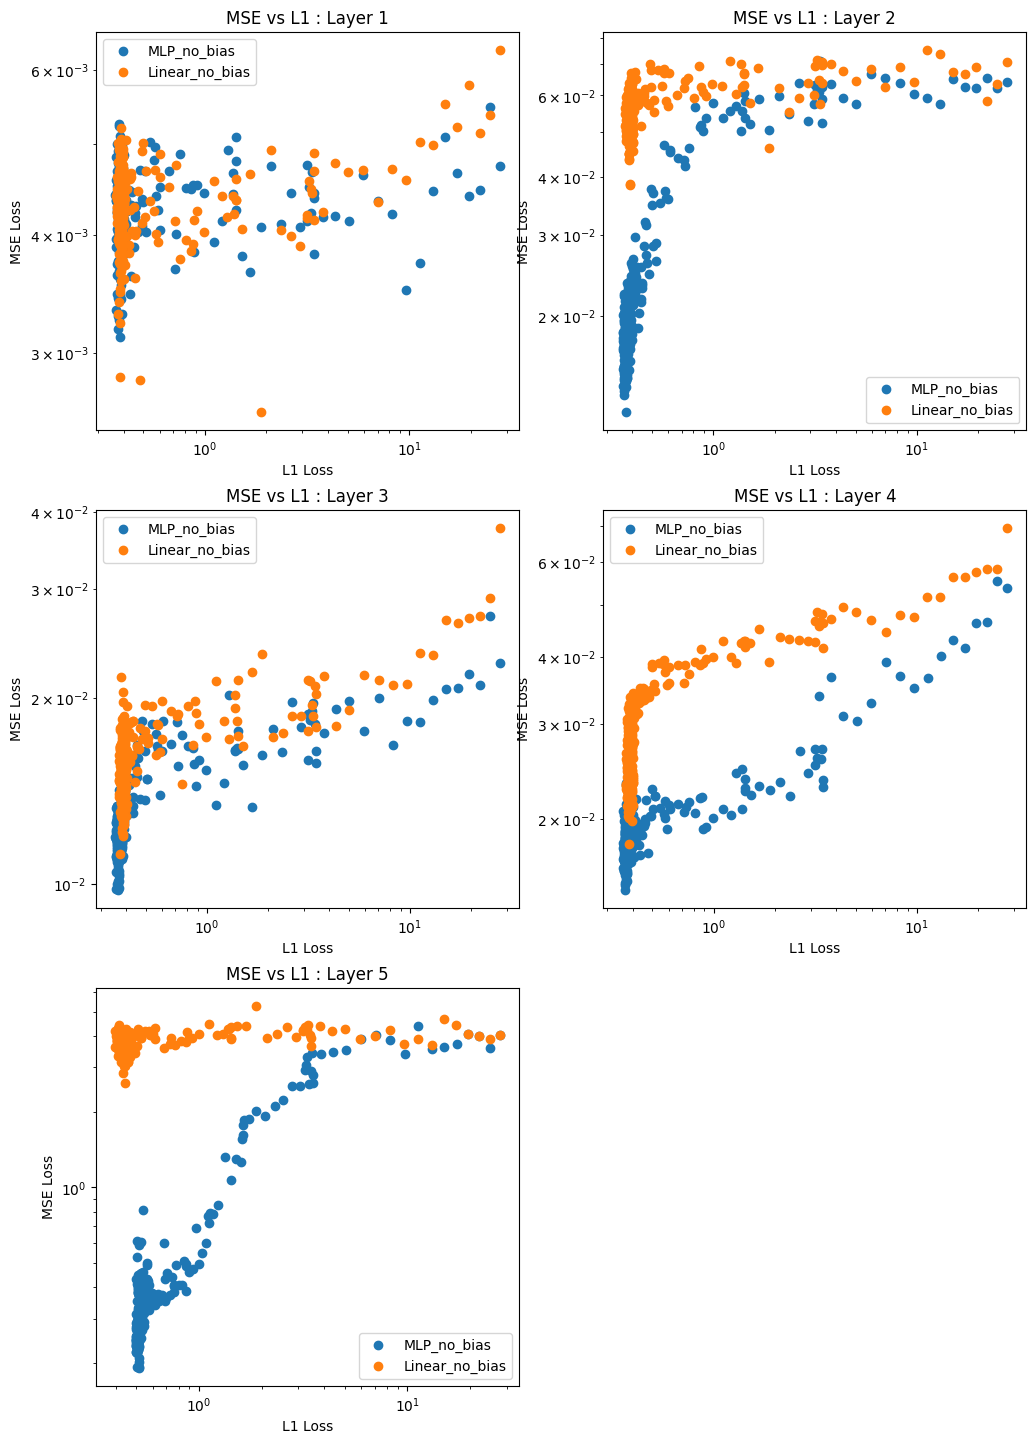

In [15]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"MSE vs L1 : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_losses_no_bias_l1[layer][-1]
    mlp_mse_loss = mlp_losses_no_bias_mse[layer][-1]
    linear_l1_loss = linear_losses_no_bias_l1[layer][-1]
    linear_mse_loss = linear_losses_no_bias_mse[layer][-1]
    # Plot
    plt.plot(mlp_l1_loss, mlp_mse_loss, 'o', label="MLP_no_bias")
    plt.plot(linear_l1_loss, linear_mse_loss, 'o', label="Linear_no_bias")
    plt.xlabel("L1 Loss")
    plt.ylabel("MSE Loss")
    # put both on logplot
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

## Sweep over MLP

In [ ]:
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, hidden_layer_size=None):
        super().__init__()
        if hidden_layer_size is None:
            hidden_layer_size = input_size
        self.linear = nn.Linear(input_size, hidden_layer_size, bias=False)
        self.linear2 = nn.Linear(hidden_layer_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

mlp_weights_no_bias = []

mlp_optimizers_no_bias = []
hidden_layer_sizes = 8
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, 2**(l1_alpha_ind+1)))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        


In [ ]:
def train_sparse_model_hidden_unit(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    batch_size = 32
    hidden_unit_models = len(sparse_weights[0])
    losses = [[[] for _ in range(len(hidden_unit_models))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(hidden_unit_models))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(hidden_unit_models))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for hidden_unit_m in range(hidden_unit_models):
                sparse_weight = sparse_weights[cache_name_ind][hidden_unit_m].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                loss = mse_loss

                loss.backward()
                optimizers[cache_name_ind][hidden_unit_m].step()
                optimizers[cache_name_ind][hidden_unit_m].zero_grad()
                losses[cache_name_ind][hidden_unit_m].append(loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, current_alive_features_ind, mse_loss, unweighted_loss
                torch.cuda.empty_cache()

        if i > 300:
            # Stop training after 1000 batches
            break
    return losses
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)

In [ ]:
# Plot MSE loss 
import matplotlib.pyplot as plt
for layer in range(len(mlp_losses_no_bias)):
    # make a new plot
    plt.figure()
    plt.title(f"MSE Losses: Layer {layer+1}")
    for l1_alpha_ind in range(len(l1_alphas)):
        plt.plot(mlp_losses_no_bias[layer][l1_alpha_ind], label=f"l1_alpha: {l1_alphas[l1_alpha_ind]}")
        # plt.plot(linear_losses_no_bias[layer][l1_alpha_ind])
    # plt.legend(["MLP_no_bias", "Linear_no_bias"])
    # log plot on y
    plt.yscale('log')
    plt.legend()

In [51]:
# Get the losses for each feature
mse = nn.MSELoss(reduction="none")
l1_alpha = 1e-3
batch_size = 32

# with dataset.formatted_as("pt"):
#     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
max_batches = 1
num_alive_features = alive_features_ind.sum(dim=1).cpu()
loss_diff = [torch.zeros(num_alive_feat) for num_alive_feat in num_alive_features]
# loss_diff = torch.zeros((len(cache_names)//2, 1024))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            if(i == 0):
                # Print the norms of both input & output
                print(f"Layer: {cache_name_ind+1}")
                print(f"Input Norms: {input_internal_activations.norm(dim=1).mean()}")
                print(f"Output Norms: {output_internal_activations.norm(dim=1).mean()}")

                # Also check dead features
                print(f"Input Dead Features: {(input_internal_activations.count_nonzero(dim=0) == 0).sum()}")
                print(f"Output Dead Features: {(output_internal_activations.count_nonzero(dim=0) == 0).sum()}")

            x_hat_mlp = mlp_weights[cache_name_ind](input_internal_activations)
            x_hat_linear = linear_weights[cache_name_ind](input_internal_activations)
            
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            index_x_hat_mlp = x_hat_mlp.index_select(dim=1, index=current_alive_features_ind)
            index_x_hat_linear = x_hat_linear.index_select(dim=1, index=current_alive_features_ind)
            index_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)

            # We want to compare the MLP loss & linear loss
            # for every feature, so we mean the batch & pos, but not the feature
            mlp_loss = mse(index_x_hat_mlp, index_output_internal_activations).mean(dim=0).cpu()
            linear_loss = mse(index_x_hat_linear, index_output_internal_activations).mean(dim=0).cpu()

            # instead of mse, do cosine sim
            # mlp_loss = torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).cpu()
            # linear_loss = torch.cosine_similarity(x_hat_linear, output_internal_activations, dim=1).cpu()
            loss_diff[cache_name_ind] += linear_loss - mlp_loss
        if(i >= max_batches):
            break
loss_diff =  [loss_d / max_batches for loss_d in loss_diff]

  0%|          | 1/10963 [00:00<37:55,  4.82it/s]

Layer: 1
Input Norms: 4.31903076171875
Output Norms: 1.771482229232788
Input Dead Features: 2142
Output Dead Features: 2360
Layer: 2
Input Norms: 4.9630279541015625
Output Norms: 3.3828701972961426
Input Dead Features: 1655
Output Dead Features: 2479
Layer: 3
Input Norms: 6.895816802978516
Output Norms: 4.891727447509766
Input Dead Features: 1200
Output Dead Features: 1954
Layer: 4
Input Norms: 8.569693565368652
Output Norms: 7.691359519958496
Input Dead Features: 1616
Output Dead Features: 1763
Layer: 5
Input Norms: 9.363563537597656
Output Norms: 52.90891647338867
Input Dead Features: 952
Output Dead Features: 2624


In [49]:
num_alive_features

tensor([1060,  724, 1255, 1590,  717])

In [11]:
mlp_loss, linear_loss.min()

(tensor([0.0202, 0.0003, 0.0018,  ..., 0.0003, 0.0003, 0.0004]),
 tensor(1.1571e-05))

In [12]:
torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).shape

torch.Size([1024])

In [13]:
output_internal_activations.shape

torch.Size([1024, 3072])

In [53]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


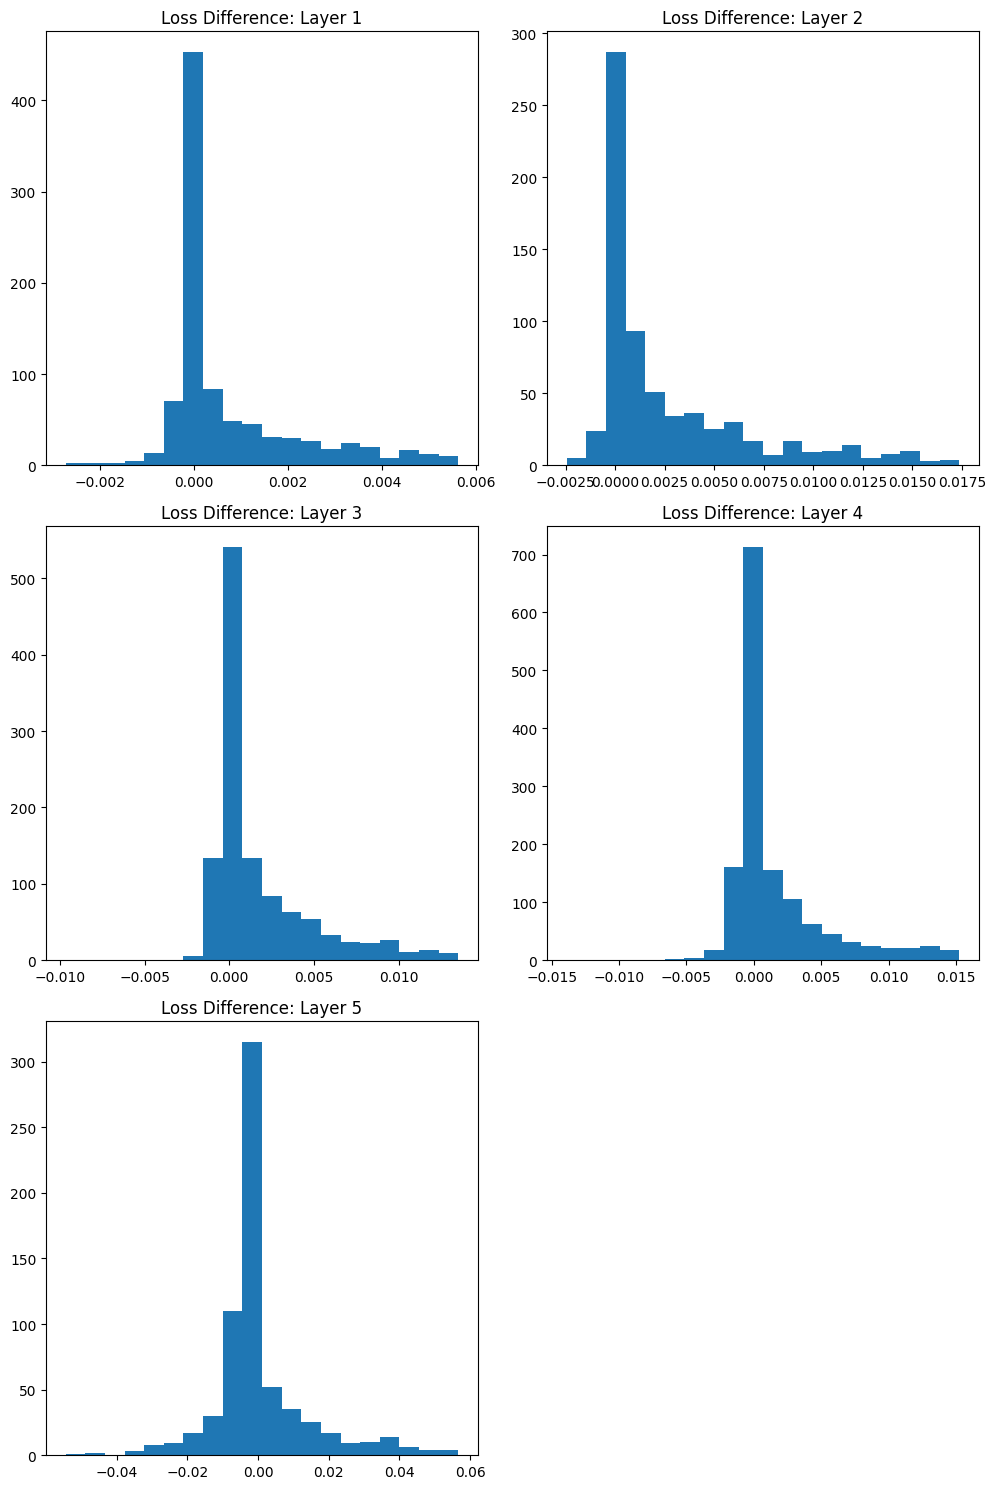

In [64]:
import matplotlib.pyplot as plt

outlier_thresh =  10.0
num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()
    filtered = loss_d[~is_outlier(loss_d, outlier_thresh)]
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.hist(filtered, bins = 20)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()


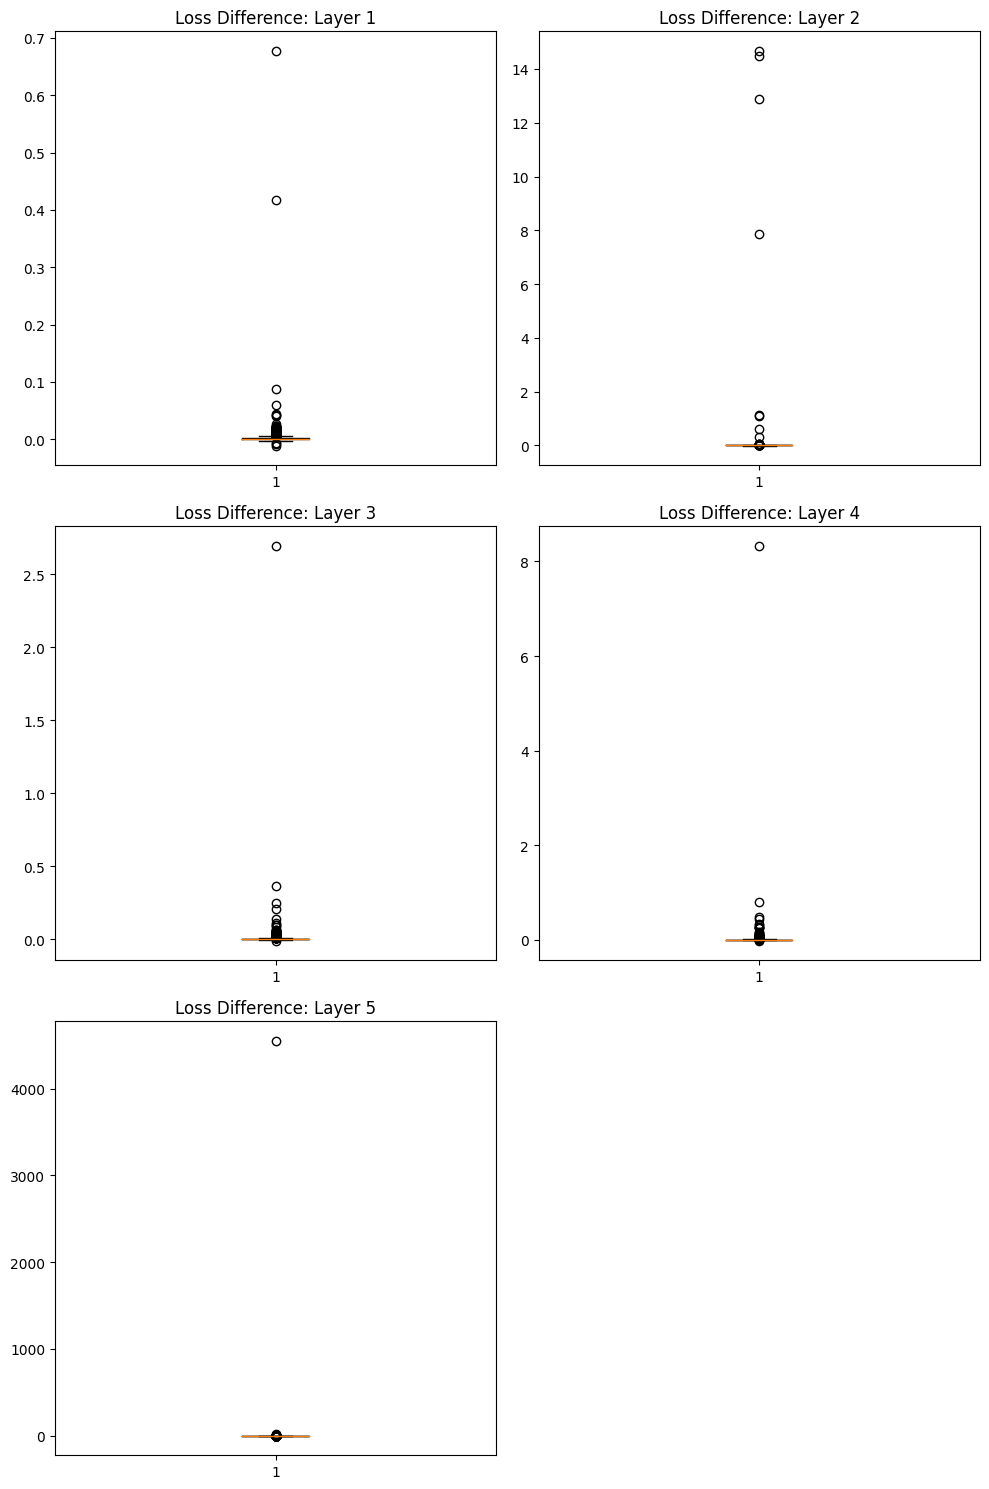

In [55]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.boxplot(loss_d)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()

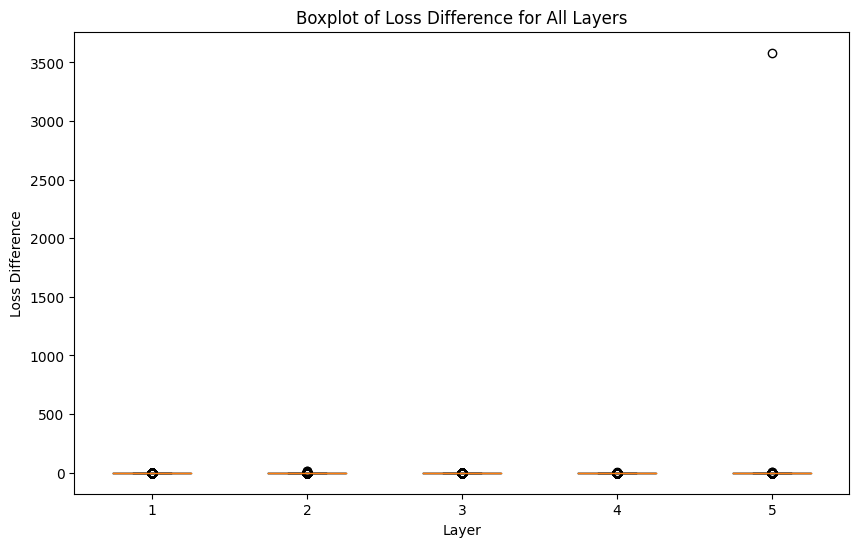

In [18]:
import matplotlib.pyplot as plt

# Collect all loss_diff data for each layer into a list
all_layers_loss_diff = [loss_diff[layer] for layer in range(len(loss_diff))]

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(all_layers_loss_diff)
plt.title("Boxplot of Loss Difference for All Layers")
plt.xlabel("Layer")
plt.ylabel("Loss Difference")

plt.show()

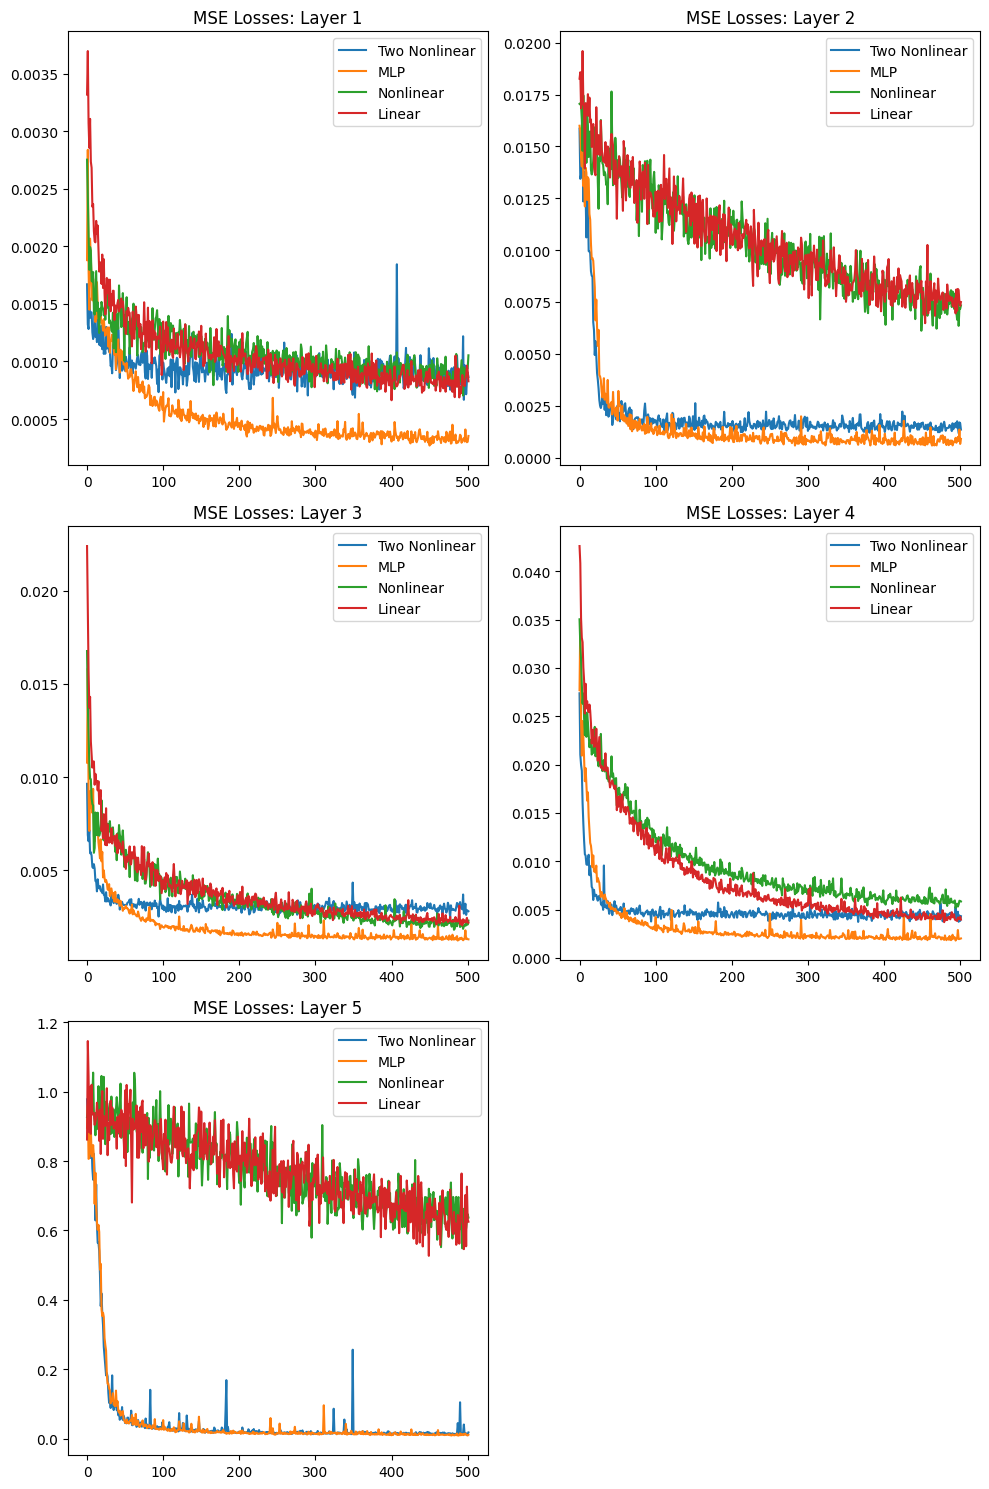

In [15]:
import matplotlib.pyplot as plt

num_layers = len(two_nonlinear_losses)
num_columns = 2  # You can adjust this based on how many plots you want per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer], label="Two Nonlinear")
    plt.plot(mlp_losses[layer], label="MLP")
    plt.plot(nonlinear_losses[layer], label="Nonlinear")
    plt.plot(linear_losses[layer], label="Linear")
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
nonlinear_losses, linear_loss

(array([0.00114306, 0.02376839, 0.00199088, 0.00503561, 0.70069301]),
 array([0.00112041, 0.02399791, 0.00216295, 0.00460967, 0.70566905]))

In [53]:
from baukit import TraceDict
mse = nn.MSELoss()
l1_alpha = 1e-3
datapoints = dataset.num_rows
batch_size = 32
losses = np.zeros(len(sparse_weights))
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(dl):
        batch = batch.to(device)
        with torch.no_grad():
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        # # Get every 2 cache names (since they're matched up)
        for cache_name_ind in range(len(cache_names)//2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[(cache_name_ind*2)]
            output_cache_name = cache_names[(cache_name_ind*2)+1]
            input_autoencoder = autoencoders[(cache_name_ind*2)]
            output_autoencoder = autoencoders[(cache_name_ind*2)+1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(input_activations, tuple)):
                input_activations = input_activations[0]
            if(isinstance(output_activations, tuple)):
                output_activations = output_activations[0]
            # Rearrange to (batch_size*seq_length, num_features)
            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n" )
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n" )
            # Encode
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            # Encode
            x_hat = sparse_weights[cache_name_ind](input_internal_activations)
            # Get loss
            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha*l1_loss
            # Backprop
            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind] = loss.item()
            if(i%50==0):
                print(f"Layers: {cache_name_ind} |  MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")


Layers: 0 |  MSE Loss: 0.0032902932725846767 | L1 Loss: 27.721176147460938
Layers: 1 |  MSE Loss: 0.045880552381277084 | L1 Loss: 27.712087631225586
Layers: 2 |  MSE Loss: 0.02548954077064991 | L1 Loss: 27.71087646484375
Layers: 3 |  MSE Loss: 0.0651974007487297 | L1 Loss: 27.717008590698242
Layers: 4 |  MSE Loss: 0.8611162900924683 | L1 Loss: 27.709190368652344
Layers: 0 |  MSE Loss: 0.001719774678349495 | L1 Loss: 24.83885955810547
Layers: 1 |  MSE Loss: 0.038391195237636566 | L1 Loss: 26.483190536499023
Layers: 2 |  MSE Loss: 0.0042221806943416595 | L1 Loss: 28.59328269958496
Layers: 3 |  MSE Loss: 0.02699713036417961 | L1 Loss: 28.991947174072266
Layers: 4 |  MSE Loss: 0.8554728031158447 | L1 Loss: 29.95911979675293
Layers: 0 |  MSE Loss: 0.0017383686499670148 | L1 Loss: 24.861730575561523
Layers: 1 |  MSE Loss: 0.035102322697639465 | L1 Loss: 26.954181671142578
Layers: 2 |  MSE Loss: 0.0031695878133177757 | L1 Loss: 29.906362533569336
Layers: 3 |  MSE Loss: 0.018583638593554497 | 

In [55]:
losses_mlp, losses

# See if the top weights have high cosine similarity between the two

In [13]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
# for f_out, f_in in indices:
    # Find the cosine similarity between these two vectors

dict_in = autoencoders[0].get_learned_dict()
dict_out = autoencoders[1].get_learned_dict()


In [1]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [24]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3108, 0.3100, 0.3035, 0.3032, 0.3001, 0.2986, 0.2986, 0.2979, 0.2974,
         0.2940], device='cuda:0'),
 tensor([2390, 2863, 2390, 1224, 2863, 1224, 1582, 2863, 1582, 1582],
        device='cuda:0'),
 tensor([3028, 3028,  247,  247,  887,  887,  887, 1904,  247,   67],
        device='cuda:0'))

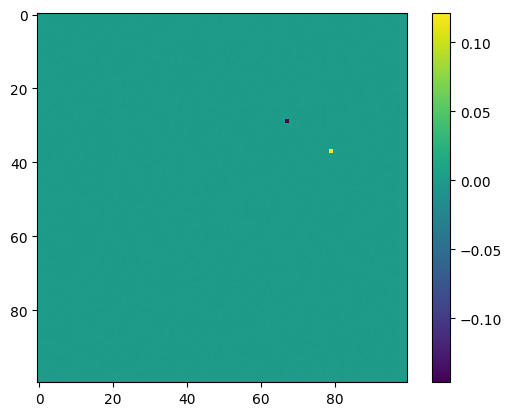

In [25]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [33]:
threshold_pos = 0.1
threshold_neg = -0.1
total_weights = Sparse_nonlinear.linear.weight.numel()
(Sparse_nonlinear.linear.weight > threshold_pos).count_nonzero() / total_weights, (Sparse_nonlinear.linear.weight < threshold_neg).count_nonzero() / total_weights, total_weights

(tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'), 9437184)

In [35]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [  11,  596],
         [  11, 1184],
         ...,
         [3059, 2127],
         [3059, 3066],
         [3065, 2497]], device='cuda:0'),
 tensor([0.1686, 0.1715, 0.1995,  ..., 0.2472, 0.1418, 0.1529], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [38]:
indices[:10]

tensor([[   1, 2191],
        [  11,  596],
        [  11, 1184],
        [  11, 2676],
        [  14, 2468],
        [  19, 1166],
        [  20,  719],
        [  28,  232],
        [  28,  662],
        [  29, 1404]], device='cuda:0')

In [39]:
indices[10:20]

tensor([[  31, 2115],
        [  31, 2399],
        [  31, 3014],
        [  34, 2422],
        [  37,   79],
        [  37, 1885],
        [  89, 1323],
        [ 103,  837],
        [ 103, 2310],
        [ 105, 1565]], device='cuda:0')

In [40]:
indices[20:30]

tensor([[ 105, 2002],
        [ 105, 2697],
        [ 106,   67],
        [ 106,  146],
        [ 106,  189],
        [ 106,  247],
        [ 106,  330],
        [ 106,  344],
        [ 106,  458],
        [ 106,  690]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

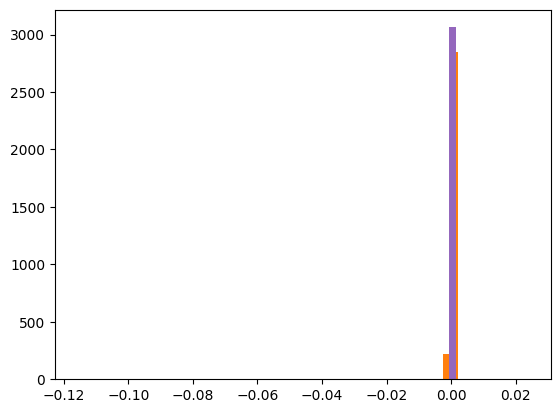

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

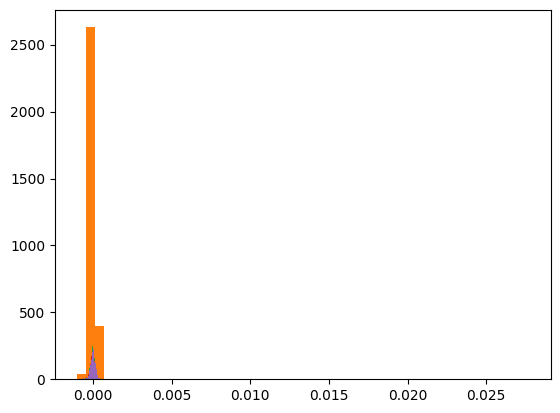

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()